In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from scipy import special

import matplotlib as mpl
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["lines.markersize"] = 4
mpl.rcParams.update({'font.size': 16})
mpl.rcParams.update({'figure.autolayout': True})
mpl.rcParams['lines.markersize'] = 7

In [9]:
# This works on Stephen's computer but not elsewhere
# so if it gives you an error, just don't worry about it
# and don't evaluate this cell
mpl.rcParams['font.serif'] = ['Computer Modern']
from matplotlib import rc
rc('text', usetex=True) 

In [3]:
# True weights and starting weights

np.random.seed(17)

d = 100 # dimension of features

A = np.random.randn(d,d)*np.sqrt(1/d)
A0 = np.random.randn(d,d)*np.sqrt(1/d)

In [4]:
# Functions

def relu(x):
    y = np.maximum(0,x)
    return y

def exact(A,X):
    Y = np.sum(relu(A@X.T+X.T),axis=0)
    return Y

def grad(A,x,y):
    """ 
    Gradient of a single example.
    A should be a square d x d matrix
    x should be (d,) size vector
    y should be a scalar
    
    Returns function and gradient (partial deriv w.r.t. A)
    """
    # Slightly faster than grad_v1, not by too much though
    d = len(x)
    D = np.zeros(d)
    z = A@x+x
    nz = np.nonzero( z >= 0)
    
    D[nz] = 1
    z = np.sum(z[nz])-y
    obj = .5*z**2
    der = z*np.outer(D,x)
    return [obj,der]    


def gradset(A,X,Y):
    """ repeatedly calls grad() for a minibatch"""
    n = np.shape(X)[0]
    Z = A@X.T+X.T
    D = np.zeros( X.shape )
    D.ravel()[ np.flatnonzero(Z.T >= 0) ] = 1
    Z = np.sum( np.maximum(0,Z), axis=0 ) - Y
    obj = la.norm(Z)**2/2/n
    der = D.T@( Z.reshape((-1,1)) * X )/n
    return [obj,der]

def erm(A,X,Y):
    n = np.shape(X)[0]
    Z = exact(A,X)
    err = .5*la.norm(Y-Z)**2/n
    return err

def trueRisk(Ak,nsmpl,A):
    """ Computes an estimate of the true risk using 'nsmpl' validation pts 
    using the .5( y - yhat)^2 loss function """
    d = np.shape(Ak)[0]
    X = np.random.randn(d,int(nsmpl))
    X = X/la.norm( X, axis=0)
    Y     = np.sum(relu(Ak@X+X),axis=0)
    Ytrue = np.sum(relu( A@X+X),axis=0)
    err   = la.norm( Y-Ytrue)**2/2/nsmpl
    return err

def classificationRisk(Ak,nsmpl,A,cutoff):
    """ Computes an estimate of the true risk using 'nsmpl' validation pts 
    using the 0-1 loss function """
    d = np.shape(Ak)[0]
    X = np.random.randn(d,int(nsmpl))
    X = X/la.norm( X, axis=0)
    Y     = np.sum(relu(Ak@X+X),axis=0)
    Ytrue = np.sum(relu( A@X+X),axis=0)
    Y     = np.sign(Y    - cutoff)
    Ytrue = np.sign(Ytrue- cutoff)
    err   = np.count_nonzero(Y-Ytrue)/nsmpl
    return err

def sgd(Ak, X, Y, c, step_decay, nepoc, A, nsmpl, b, cutoff):
    n = np.shape(X)[0]
    m = int(n/b)
    i = 1
    for epoch in range(nepoc):
        perm = np.random.choice(n,size=n,replace=True)
        for j in range(m):
            if b == 1:
                x = X[perm[j],:]
                y = Y[perm[j]]
                [obj,der] = grad(Ak,x,y)
            if b > 1:
                bX = X[perm[b*j:b*(j+1)],:]
                bY = Y[perm[b*j:b*(j+1)]]
                [obj,der] = gradset(Ak,bX,bY)
            eta = c/i**step_decay
            Ak -= eta*der
            i += 1
    r_err = trueRisk(Ak,nsmpl,A)
    c_err = classificationRisk(Ak,nsmpl,A,cutoff)
    return [r_err,c_err]

In [ ]:
# Compute true risk/mis-classification vs. sample size
# ** Don't run this cell if you want to use pre-computed data **

c = .1
step_decay = 1
nepoc = 10     # number of epochs
nsmpl = 1000   # number of validation pts to estimate true risk
b = 1          # size of minibatch
cutoff = 5     # bias term for hyperplane classifier
n = 250
num_trials = 1000

r_errs = np.zeros(num_trials)
c_errs = np.zeros(num_trials)
for i in range(num_trials):
    print(i)
    X = np.random.randn(n,d)*np.sqrt(1/d)
    X /= la.norm(X,axis=1).reshape(n,1)
    Y = exact(A,X)
    Ak = A0
    [r_err,c_err] = sgd(Ak, X, Y, c, step_decay, nepoc, A, nsmpl, b, cutoff)
    r_errs[i] = r_err
    c_errs[i] = c_err

np.savetxt('genr_r_errs.csv', r_errs, delimiter=',')
np.savetxt('genr_c_errs.csv', c_errs, delimiter=',')
print("Finished saving data to csv file"

In [6]:
r_errs = np.loadtxt('genr_r_errs.csv',  delimiter=',')
c_errs = np.loadtxt('genr_c_errs.csv',  delimiter=',')
# r_errs = np.loadtxt('data/genr_r_errs.csv',  delimiter=',')
# c_errs = np.loadtxt('data/genr_c_errs.csv',  delimiter=',')
cdf = np.arange(len(r_errs))/float(len(r_errs))
r_errs = np.sort(r_errs)
c_errs = np.sort(c_errs)

In [ ]:
# Find line of best-fit (possibly after doing a transformation)
def bestFit( x, y):
    """ returns slope,intercept for best fit of the data (x,y)"""
    # Form Vandermonde matrix
    n = len(x)
    V = np.vstack( (x.ravel(), np.ones(n)) ).T 
    
    beta = la.lstsq(V,y,rcond=None)[0]

    slope = beta[0]
    intercept = beta[1]

    return slope,intercept

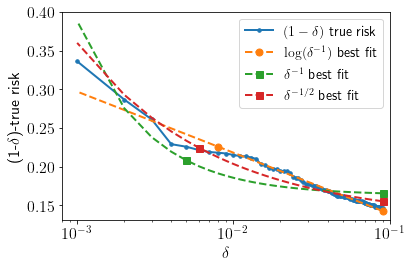

In [113]:
# Figure 1, left
fig, ax = plt.subplots()
deltas = 1-cdf[-90:] # behavior of delta near 1 is not interesting; we care about delta --> 0
data   = r_errs[-90:]

ax.semilogx(deltas,data,'.-',label="$(1-\delta)$ true risk")

# Make a line of best fit, using function dependence f(delta)
f = lambda delta : np.log(1/delta)
slp,intrcpt = bestFit( f(deltas), data)
ax.semilogx( deltas, slp*f(deltas) + intrcpt, 'o--', markevery=.45,label="$\log(\delta^{-1})$ best fit")

f = lambda delta : 1/delta
slp,intrcpt = bestFit( f(deltas), data)
ax.semilogx( deltas, slp*f(deltas) + intrcpt, 's--', markevery=.5,label="$\delta^{-1}$ best fit")

f = lambda delta : 1/np.sqrt(delta)
slp,intrcpt = bestFit( f(deltas), data)
ax.semilogx( deltas, slp*f(deltas) + intrcpt, 's--', markevery=.5,label="$\delta^{-1/2}$ best fit")

# ax.semilogx(1-cdf,r_errs,'.-',label="$(1-\delta)$ true risk")
# ax.semilogx( deltas, np.log(1/deltas)/20, 'o--', markevery=.2,label="constant$\\times\log(\delta^{-1})$ reference")
# ax.semilogx( deltas, 1/deltas/2000, 's--', markevery=.2,label="constant$\\times\delta^{-1}$ reference")
# ax.semilogx( deltas, 1/np.sqrt(deltas)/50, 'd--', markevery=.2,label="constant$\\times\delta^{-1/2}$ reference")
# ax.invert_xaxis()
plt.xlabel('$\delta$')
plt.ylabel('(1-$\delta$)-true risk')
# plt.ylim(bottom=0,top=0.4)
plt.legend(fontsize=14) #,loc="lower left")
plt.xlim(right=.1)
plt.savefig('truerisk_v2.pdf')
plt.show()

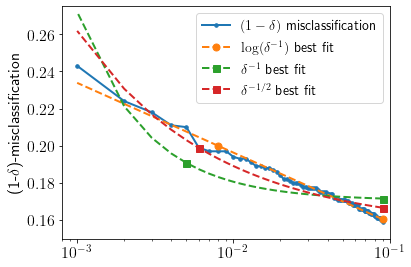

In [114]:
# Figure 1, right
fig, ax = plt.subplots()

deltas = 1-cdf[-90:] # behavior of delta near 1 is not interesting; we care about delta --> 0
data   = c_errs[-90:]

ax.semilogx(deltas,data,'.-',label="$(1-\delta)$ misclassification")

# Make a line of best fit, using function dependence f(delta)
f = lambda delta : np.log(1/delta)
slp,intrcpt = bestFit( f(deltas), data)
ax.semilogx( deltas, slp*f(deltas) + intrcpt, 'o--', markevery=.45,label="$\log(\delta^{-1})$ best fit")

f = lambda delta : 1/delta
slp,intrcpt = bestFit( f(deltas), data)
ax.semilogx( deltas, slp*f(deltas) + intrcpt, 's--', markevery=.5,label="$\delta^{-1}$ best fit")

f = lambda delta : 1/np.sqrt(delta)
slp,intrcpt = bestFit( f(deltas), data)
ax.semilogx( deltas, slp*f(deltas) + intrcpt, 's--', markevery=.5,label="$\delta^{-1/2}$ best fit")

# ax.semilogx( deltas, np.log(1/deltas)/30, 'o--', markevery=.2,label="constant$\\times\log(\delta^{-1})$ reference")
# ax.semilogx( deltas, 1/deltas/2000, 's--', markevery=.2,label="constant$\\times\delta^{-1}$ reference")
# ax.semilogx( deltas, 1/np.sqrt(deltas)/500+.2, 'd--', markevery=.2,label="constant$\\times\delta^{-1/2}$ reference")
# plt.ylim(bottom=0,top=0.3)
plt.ylim(bottom=.15,top=0.275)
plt.legend(fontsize=14) #,loc="lower left")
plt.xlim(right=.1)
plt.ylabel('(1-$\delta$)-misclassification')
plt.savefig('misclassification_v2.pdf')
plt.show()